# nvidia/llama-embed-nemotron-8b
It is a state-of-the-art model for text embedding which has a maximum input sequence length of 32768 tokens! So we do not need to do any chunking.

<b>Why this model?</b>

It scores highest for zero-shot embedding models in this leaderboard: https://huggingface.co/spaces/mteb/leaderboard

### Since we use GPU for calculations, Do not rerun this code, otherwise you will lose the results.

In [4]:
import torch
from transformers import AutoTokenizer, AutoModel
import torch.nn.functional as F

# Model name from Hugging Face
MODEL_NAME = "nvidia/llama-embed-nemotron-8b"
# Instruction for Semantic Textual Similarity (STS) tasks, as per model documentation
STS_INSTRUCTION = "Retrieve semantically similar text."

In [5]:
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, trust_remote_code=True, padding_side="left")
model = AutoModel.from_pretrained(MODEL_NAME, trust_remote_code=True, torch_dtype=torch.float32)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()

`torch_dtype` is deprecated! Use `dtype` instead!


Fetching 4 files:   0%|          | 0/4 [00:00<?, ?it/s]

model-00003-of-00004.safetensors:   0%|          | 0.00/4.92G [00:00<?, ?B/s]

model-00002-of-00004.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00001-of-00004.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

LlamaBidirectionalModel(
  (embed_tokens): Embedding(128256, 4096)
  (layers): ModuleList(
    (0-31): 32 x LlamaDecoderLayer(
      (self_attn): LlamaAttention(
        (q_proj): Linear(in_features=4096, out_features=4096, bias=False)
        (k_proj): Linear(in_features=4096, out_features=1024, bias=False)
        (v_proj): Linear(in_features=4096, out_features=1024, bias=False)
        (o_proj): Linear(in_features=4096, out_features=4096, bias=False)
      )
      (mlp): LlamaMLP(
        (gate_proj): Linear(in_features=4096, out_features=14336, bias=False)
        (up_proj): Linear(in_features=4096, out_features=14336, bias=False)
        (down_proj): Linear(in_features=14336, out_features=4096, bias=False)
        (act_fn): SiLUActivation()
      )
      (input_layernorm): LlamaRMSNorm((4096,), eps=1e-05)
      (post_attention_layernorm): LlamaRMSNorm((4096,), eps=1e-05)
    )
  )
  (norm): LlamaRMSNorm((4096,), eps=1e-05)
  (rotary_emb): LlamaRotaryEmbedding()
)

# Get Vector Embedding

In [6]:
def get_embedding(text):
    input_text = f"Instruct: {STS_INSTRUCTION}\nQuery: {text}"
    
    inputs = tokenizer(
        input_text,
        max_length=8192,
        padding=True,
        truncation=True,
        return_tensors="pt"
    ).to(device)

    with torch.no_grad():
        model_output = model(**inputs)

    token_embeddings = model_output.last_hidden_state
    attention_mask = inputs['attention_mask']

    # Expand mask to match embedding size
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    
    # Sum non-padded embeddings and normalize by the number of non-padded tokens
    sum_embeddings = torch.sum(token_embeddings * input_mask_expanded, 1)
    sum_mask = torch.clamp(input_mask_expanded.sum(1), min=1e-9)
    mean_embedding = sum_embeddings / sum_mask
    
    # Normalize the embeddings (L2 normalization is required for cosine similarity)
    normalized_embedding = F.normalize(mean_embedding, p=2, dim=1)
    
    return normalized_embedding[0]

In [10]:
import pandas as pd
df = pd.read_csv('datasets.csv')
df

,topic,length,AI_model,humanizer,AI_essay,humanized_essay
0,1,1,gemini2.5pro,AIHumanizer,The integration of social media into the lives...,The way social media has woven itself into the...
1,1,1,gemini2.5pro,Grammarly,The integration of social media into the lives...,Social media has become a big part of young pe...
2,1,1,gemini2.5pro,HumanizeAI,The integration of social media into the lives...,The penetration of social media into the lives...
3,1,1,gemini2.5pro,Quillbot,The integration of social media into the lives...,Social media's introduction into young people'...
4,1,1,gemini2.5pro,UndetectableAI,The integration of social media into the lives...,Young people face a harmful environment throug...
...,...,...,...,...,...,...
175,5,3,gpt4.0,Grammarly,Childhood is often remembered through the lens...,Childhood is frequently recalled as a period m...
176,5,3,gpt4.0,HumanizeAI,Childhood is often remembered through the lens...,Childhood is often remembered as a realm of si...
177,5,3,gpt4.0,Quillbot,Childhood is often remembered through the lens...,Childhood is frequently viewed through the pri...
178,5,3,gpt4.0,UndetectableAI,Childhood is often remembered through the lens...,People tend to recall their childhood through ...


In [12]:
df_embeddings = df.copy()
df_embeddings['AI_embedding'] = None
df_embeddings['humanized_embedding'] = None
for i, rows in df.iterrows():
    ai_embedding = get_embedding(rows['AI_essay'])
    humanized_embedding = get_embedding(rows['humanized_essay'])
    df_embeddings.at[i, 'AI_embedding'] = ai_embedding
    df_embeddings.at[i, 'humanized_embedding'] = humanized_embedding
df_embeddings.head()

,topic,length,AI_model,humanizer,AI_essay,humanized_essay,AI_embedding,humanized_embedding
0,1,1,gemini2.5pro,AIHumanizer,The integration of social media into the lives...,The way social media has woven itself into the...,"[tensor(-0.0072, device='cuda:0'), tensor(-0.0...","[tensor(-0.0130, device='cuda:0'), tensor(0.00..."
1,1,1,gemini2.5pro,Grammarly,The integration of social media into the lives...,Social media has become a big part of young pe...,"[tensor(-0.0072, device='cuda:0'), tensor(-0.0...","[tensor(-0.0067, device='cuda:0'), tensor(0.00..."
2,1,1,gemini2.5pro,HumanizeAI,The integration of social media into the lives...,The penetration of social media into the lives...,"[tensor(-0.0072, device='cuda:0'), tensor(-0.0...","[tensor(-0.0043, device='cuda:0'), tensor(-0.0..."
3,1,1,gemini2.5pro,Quillbot,The integration of social media into the lives...,Social media's introduction into young people'...,"[tensor(-0.0072, device='cuda:0'), tensor(-0.0...","[tensor(-0.0004, device='cuda:0'), tensor(-0.0..."
4,1,1,gemini2.5pro,UndetectableAI,The integration of social media into the lives...,Young people face a harmful environment throug...,"[tensor(-0.0072, device='cuda:0'), tensor(-0.0...","[tensor(0.0095, device='cuda:0'), tensor(0.001..."


# Calculate Cosine Similarity

In [13]:
def calculate_similarity(embedding1, embedding2):
    similarity = F.cosine_similarity(embedding1.unsqueeze(0), embedding2.unsqueeze(0))
    return similarity.item()

In [17]:
df_cosim = df_embeddings.copy()
df_cosim['Nemotron_cosim'] = None
for i, rows in df_embeddings.iterrows():
    similarity = calculate_similarity(rows['AI_embedding'], rows['humanized_embedding'])
    df_cosim.at[i, 'Nemotron_cosim'] = similarity
df_cosim.head()

,topic,length,AI_model,humanizer,AI_essay,humanized_essay,AI_embedding,humanized_embedding,Nemotron_cosim
0,1,1,gemini2.5pro,AIHumanizer,The integration of social media into the lives...,The way social media has woven itself into the...,"[tensor(-0.0072, device='cuda:0'), tensor(-0.0...","[tensor(-0.0130, device='cuda:0'), tensor(0.00...",0.907571
1,1,1,gemini2.5pro,Grammarly,The integration of social media into the lives...,Social media has become a big part of young pe...,"[tensor(-0.0072, device='cuda:0'), tensor(-0.0...","[tensor(-0.0067, device='cuda:0'), tensor(0.00...",0.848066
2,1,1,gemini2.5pro,HumanizeAI,The integration of social media into the lives...,The penetration of social media into the lives...,"[tensor(-0.0072, device='cuda:0'), tensor(-0.0...","[tensor(-0.0043, device='cuda:0'), tensor(-0.0...",0.934771
3,1,1,gemini2.5pro,Quillbot,The integration of social media into the lives...,Social media's introduction into young people'...,"[tensor(-0.0072, device='cuda:0'), tensor(-0.0...","[tensor(-0.0004, device='cuda:0'), tensor(-0.0...",0.936948
4,1,1,gemini2.5pro,UndetectableAI,The integration of social media into the lives...,Young people face a harmful environment throug...,"[tensor(-0.0072, device='cuda:0'), tensor(-0.0...","[tensor(0.0095, device='cuda:0'), tensor(0.001...",0.844359


In [18]:
#remove the outlier
df_cosim_cleaned = df_cosim.drop(index=161)
df_cosim_cleaned.reset_index(inplace=True, drop=True)
df_cosim_humanizer_length = df_cosim_cleaned.groupby(['humanizer', 'length'])['Nemotron_cosim'].mean().reset_index()
df_cosim_humanizer_length['length'] = df_cosim_humanizer_length['length'].map({1: 'short', 2: 'medium', 3: 'long'})
df_cosim_humanizer_length

,humanizer,length,Nemotron_cosim
0,AIHumanizer,short,0.944642
1,AIHumanizer,medium,0.954717
2,AIHumanizer,long,0.9601
3,Grammarly,short,0.94194
4,Grammarly,medium,0.937441
5,Grammarly,long,0.92599
6,HumanizeAI,short,0.920761
7,HumanizeAI,medium,0.919458
8,HumanizeAI,long,0.941691
9,Quillbot,short,0.94667


In [19]:
df_cosim_cleaned = df_cosim.drop(index=161)
df_cosim_cleaned.reset_index(inplace=True, drop=True)
df_cosim_humanizer = df_cosim_cleaned.groupby('humanizer')['Nemotron_cosim'].mean().reset_index()
df_cosim_humanizer = df_cosim_humanizer.sort_values(by='Nemotron_cosim')
df_cosim_humanizer

,humanizer,Nemotron_cosim
5,writehuman.ai,0.894185
4,UndetectableAI,0.896103
2,HumanizeAI,0.927303
1,Grammarly,0.935124
0,AIHumanizer,0.953153
3,Quillbot,0.955062


# Visualization

In [20]:
from matplotlib import pyplot as plt
import seaborn as sns

In [21]:
custom_palette = sns.color_palette(['#B08A4C', '#675200', '#250000'])
sns.set_palette(custom_palette)

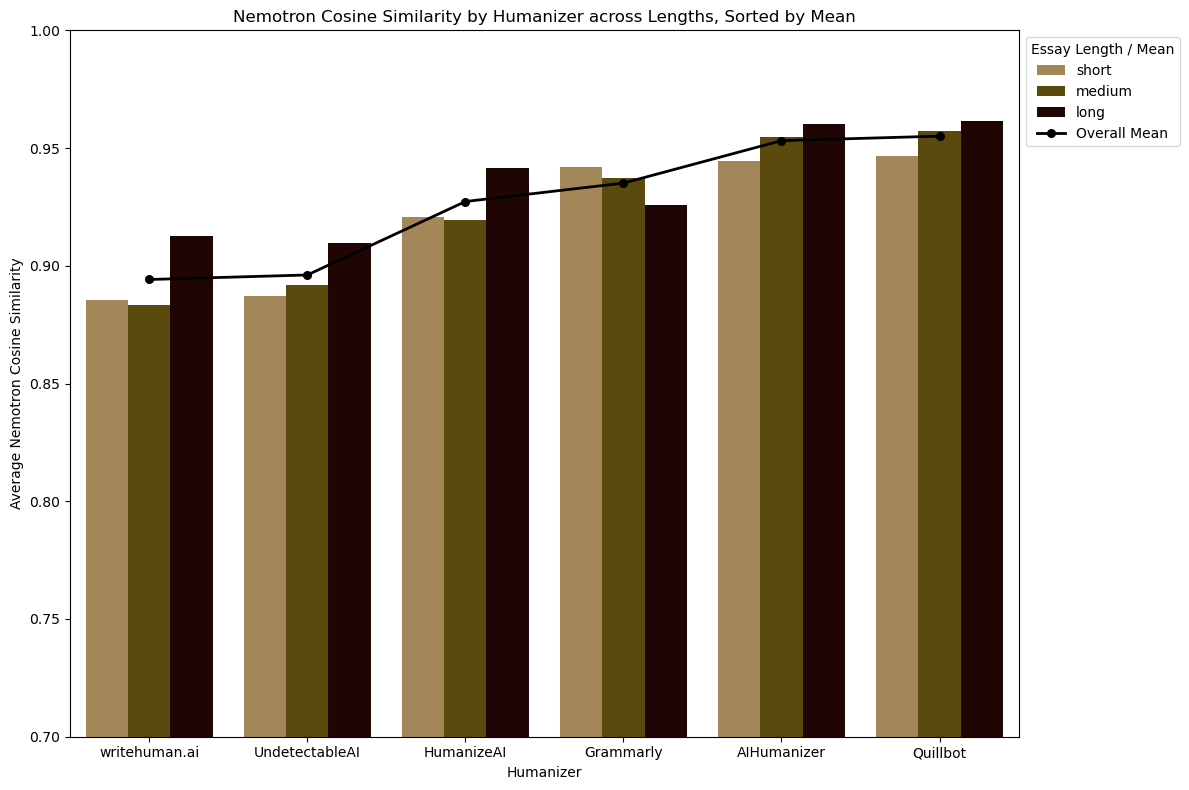

In [23]:
sorted_humanizer_order = df_cosim_humanizer['humanizer'].tolist()

from matplotlib.lines import Line2D
plt.figure(figsize=(12,8))

#bar plot
ax = sns.barplot(data=df_cosim_humanizer_length, x='humanizer', y='Nemotron_cosim', hue='length', order=sorted_humanizer_order, )

#line plot of mean
sns.pointplot(data=df_cosim_humanizer, x='humanizer', y='Nemotron_cosim', color='black', markers='o', label='Overall Mean', order=sorted_humanizer_order, linewidth=2)

plt.title('Nemotron Cosine Similarity by Humanizer across Lengths, Sorted by Mean')
plt.xlabel('Humanizer')
plt.ylabel('Average Nemotron Cosine Similarity')

handles, labels = ax.get_legend_handles_labels()

handles.append(Line2D([0], [0], color='black', marker='_', linestyle='-', markersize=3, linewidth=0.4))
ax.legend(handles=handles, labels=labels, title='Essay Length / Mean', bbox_to_anchor=(1, 1), loc='upper left')
#set y-axis limit
plt.ylim(0.7, 1.0)
plt.tight_layout()
plt.show()

# Save temporary df for later use

In [ ]:
df_embeddings['AI_embedding'] = df_embeddings['AI_embedding'].apply(lambda x: x.cpu().numpy())
df_embeddings['humanized_embedding'] = df_embeddings['humanized_embedding'].apply(lambda x: x.cpu().numpy())

In [32]:
df_embeddings.to_parquet('./df_Nemotron_embeddings.parquet', index=False)

In [33]:
df_cosim['AI_embedding'] = df_cosim['AI_embedding'].apply(lambda x: x.cpu().numpy())
df_cosim['humanized_embedding'] = df_cosim['humanized_embedding'].apply(lambda x: x.cpu().numpy())
df_cosim.to_parquet('./df_Nemotron_cosim.parquet', index=False)